# Diabetes Risk Analysis - Multi-Class Classification Analysis

***

## Scope of Notebook

This analysis extends the classification task to the complete 3-class problem, distinguishing between Healthy, Prediabetes, and Diabetes states. The primary objective involves developing multi-class classification models capable of identifying individuals across the full spectrum of diabetes risk, with particular emphasis on detecting the challenging Prediabetes category.

**Target Variable:** `Diabetes_012` (0=Healthy, 1=Prediabetes, 2=Diabetes)

Table of contents:

*   [1. Data Preparation and Preprocessing](#1-data-preparation-and-preprocessing)
*   [2. Multi-Class Model Training](#2-multi-class-model-training)
*   [3. Threshold Optimization (Class 2: Diabetes)](#3-threshold-optimization-class-2-diabetes)
*   [4. Final Model Evaluation](#4-final-model-evaluation)
*   [5. Aggregated Weighting Strategy for Prediabetes Detection](#5-aggregated-weighting-strategy-for-prediabetes-detection)
*   [6. Ensemble Approach (Balanced Random Forest)](#6-ensemble-approach-balanced-random-forest)
*   [7. Balanced Random Forest Optimization](#7-balanced-random-forest-optimization)
*   [8. Threshold Optimization for Balanced Random Forest](#8-threshold-optimization-for-balanced-random-forest)
*   [9. SHAP Analysis (Model Interpretation)](#9-shap-analysis-model-interpretation)
*   [10. Final Model Comparison Leaderboard](#10-final-model-comparison-leaderboard)
*   [11. Automated Model Selection](#11-automated-model-selection)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import optuna
from optuna.samplers import TPESampler
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

c:\Users\Dell\anaconda3\envs\faidm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation and Preprocessing

The modeling pipeline is established through systematic data preparation:
*   **Data Loading:** Import of the preprocessed dataset from pickle format.
*   **Feature Selection:** Utilization of a refined feature subset derived from prior feature importance analysis: Physical_Distress_Ratio, Healthy_Habit_Score, Sedentary_Risk, Age, BMI, and GenHlth.
*   **Stratified Splitting:** Implementation of train-test split (80/20 ratio) with stratification to maintain class distribution proportions.
*   **Feature Scaling:** Application of StandardScaler for normalization (required for Logistic Regression).
*   **Class Balancing:** Deployment of SMOTE (Synthetic Minority Over-sampling Technique) with strategy='not majority' to oversample Prediabetes and Diabetes classes while preserving the majority Healthy class distribution.

In [2]:
# 1. Load Data
import os

# Try loading the most raw processed file first to ensure we have the target
pkl_path = '../data/processed/diabetes_final_processed.pkl'
if not os.path.exists(pkl_path):
    pkl_path = 'diabetes-risk-analysis/data/processed/diabetes_final_processed.pkl'

print(f"Loading data from: {pkl_path}")
df = pd.read_pickle(pkl_path)

if 'Diabetes_012' not in df.columns:
    print("'Diabetes_012' not found in final processed file. Trying 'diabetes_with_clusters.pkl'...")
    alt_path = '../data/processed/diabetes_with_clusters.pkl'
    if not os.path.exists(alt_path):
        alt_path = 'diabetes-risk-analysis/data/processed/diabetes_with_clusters.pkl'
    
    if os.path.exists(alt_path):
        df_alt = pd.read_pickle(alt_path)
        if 'Diabetes_012' in df_alt.columns:
            print("Found target in 'diabetes_with_clusters.pkl'. Merging or using that.")
            df = df_alt
        else:
            print("Available columns in alt file:", df_alt.columns.tolist())
            raise KeyError("'Diabetes_012' not found in alternative file either.")
    else:
        print("Available columns in loaded file:", df.columns.tolist())
        raise KeyError("'Diabetes_012' not found and alternative file missing.")


# 2. Define Features & Target
# Ensure the target is 0, 1, 2
if df['Diabetes_012'].dtype == 'float':
    df['Diabetes_012'] = df['Diabetes_012'].astype(int)

# Use ONLY the specified features
features = [
    'Physical_Distress_Ratio', 
    'Healthy_Habit_Score', 
    'Sedentary_Risk', 
    'Age', 
    'BMI', 
    'GenHlth'
]

# Verify columns exist
missing_cols = [c for c in features if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns: {missing_cols}")

X = df[features]
y = df['Diabetes_012']

print("Target Distribution:")
print(y.value_counts(normalize=True))

# 3. Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Apply SMOTE (not majority)
# Strategy 'not majority': resample all classes except the majority class
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal Train Shape: {X_train.shape}")
print(f"Resampled Train Shape: {X_train_resampled.shape}")
print("Resampled Distribution:")
print(pd.Series(y_train_resampled).value_counts())

Loading data from: ../data/processed/diabetes_final_processed.pkl
'Diabetes_012' not found in final processed file. Trying 'diabetes_with_clusters.pkl'...
Found target in 'diabetes_with_clusters.pkl'. Merging or using that.
Target Distribution:
Diabetes_012
0    0.827114
2    0.152741
1    0.020145
Name: proportion, dtype: float64

Original Train Shape: (183824, 6)
Resampled Train Shape: (456129, 6)
Resampled Distribution:
Diabetes_012
0    152043
2    152043
1    152043
Name: count, dtype: int64

Original Train Shape: (183824, 6)
Resampled Train Shape: (456129, 6)
Resampled Distribution:
Diabetes_012
0    152043
2    152043
1    152043
Name: count, dtype: int64


## 2. Multi-Class Model Training

Three classification algorithms are trained to address the multi-class problem:
*   **Logistic Regression (Multinomial):** Linear model serving as baseline for identifying linear separability between classes.
*   **Random Forest:** Ensemble tree-based approach capable of capturing non-linear relationships and feature interactions.
*   **XGBoost:** Gradient boosting framework typically providing superior predictive performance through iterative error correction.

**Feature Selection Validation:** Recursive Feature Elimination with Cross-Validation (RFECV) is applied using Random Forest as the base estimator to confirm the optimal feature subset, with F1-weighted as the scoring criterion.

**Hyperparameter Optimization:** Optuna's Tree-structured Parzen Estimator (TPE) is employed with F1-weighted score as the optimization metric to ensure balanced performance across all three classes. Each model undergoes 20 optimization trials with 3-fold stratified cross-validation.

Running RFECV (Recursive Feature Elimination)...
Optimal number of features: 6
Selected Features: ['Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']
Optimal number of features: 6
Selected Features: ['Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']


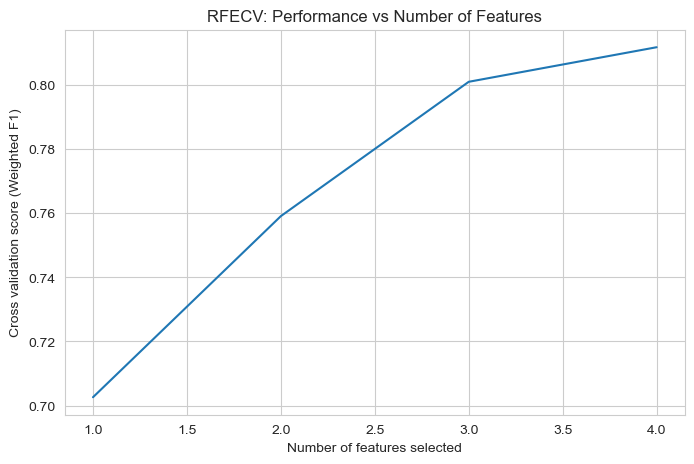

RFECV suggests keeping all features.


In [3]:
# --- Feature Selection (RFECV) ---
print("Running RFECV (Recursive Feature Elimination)...")

# Initialize Random Forest as the estimator
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

# Initialize RFECV
# Scoring: f1_weighted is balanced for multi-class
rfecv = RFECV(
    estimator=rf_selector,
    step=1,
    cv=StratifiedKFold(3),
    scoring='f1_weighted',
    min_features_to_select=3
)

# Fit RFECV
# X_train_resampled is a numpy array.
rfecv.fit(X_train_resampled, y_train_resampled)

print(f"Optimal number of features: {rfecv.n_features_}")

# Map support_ back to feature names
# We know 'X' was our original dataframe
selected_indices = np.where(rfecv.support_)[0]
selected_features = [features[i] for i in selected_indices]
print(f"Selected Features: {selected_features}")

# Plot Performance
plt.figure(figsize=(8, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (Weighted F1)")
n_features = range(rfecv.min_features_to_select, 
                   len(rfecv.cv_results_['mean_test_score']) + rfecv.min_features_to_select)
# Note: cv_results_['mean_test_score'] length depends on total features vs steps
# For small feature set, just range(min, max+1) usually aligns
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("RFECV: Performance vs Number of Features")
plt.show()

# If specific features were dropped, we could filter X_train/X_test here.
# For this analysis, we'll continue with the full set unless the drop is significant.
if rfecv.n_features_ < len(features):
    print("RFECV suggests dropping some features. You may manually adjust the feature list if desired.")
else:
    print("RFECV suggests keeping all features.")

In [4]:
# --- Hyperparameter Optimization with Optuna ---
# We optimize for 'f1_weighted' or 'recall_weighted' to balance performance across classes.

# 1. Logistic Regression
def objective_lr(trial):
    C = trial.suggest_float('C', 0.001, 10.0, log=True)
    # saga is good for large datasets and handles multinomial loss
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga']) 
    
    model = LogisticRegression(
        C=C, 
        solver=solver, 
        # multi_class='multinomial', # Removed: deprecated/removed in recent sklearn versions
        max_iter=1000, 
        random_state=42
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_weighted')
    return scores.mean()

print("Optimizing Logistic Regression...")
study_lr = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lr.optimize(objective_lr, n_trials=20, show_progress_bar=True)

# 2. Random Forest
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_weighted')
    return scores.mean()

print("\nOptimizing Random Forest...")
study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=20, show_progress_bar=True)

# 3. XGBoost
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    
    model = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    )
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_weighted')
    return scores.mean()

print("\nOptimizing XGBoost...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True)

print("\nOptimization Complete.")

[I 2026-02-07 10:37:37,679] A new study created in memory with name: no-name-99a11475-0da8-481f-80fb-87adbcf99944


Optimizing Logistic Regression...


Best trial: 0. Best value: 0.477014:   5%|▌         | 1/20 [00:01<00:23,  1.23s/it]

[I 2026-02-07 10:37:38,915] Trial 0 finished with value: 0.4770139550063268 and parameters: {'C': 0.03148911647956861, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.4770139550063268.


Best trial: 1. Best value: 0.477032:  10%|█         | 2/20 [00:02<00:22,  1.23s/it]

[I 2026-02-07 10:37:40,138] Trial 1 finished with value: 0.4770318365872568 and parameters: {'C': 0.24810409748678125, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.4770318365872568.


Best trial: 1. Best value: 0.477032:  15%|█▌        | 3/20 [00:03<00:21,  1.29s/it]

[I 2026-02-07 10:37:41,497] Trial 2 finished with value: 0.4763375145822894 and parameters: {'C': 0.0017073967431528124, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.4770318365872568.


Best trial: 1. Best value: 0.477032:  20%|██        | 4/20 [00:12<01:09,  4.32s/it]

[I 2026-02-07 10:37:50,472] Trial 3 finished with value: 0.47694500402428147 and parameters: {'C': 0.679657809075816, 'solver': 'saga'}. Best is trial 1 with value: 0.4770318365872568.


Best trial: 4. Best value: 0.477045:  25%|██▌       | 5/20 [00:13<00:47,  3.17s/it]

[I 2026-02-07 10:37:51,591] Trial 4 finished with value: 0.47704480785721254 and parameters: {'C': 2.1368329072358767, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  30%|███       | 6/20 [00:21<01:04,  4.57s/it]

[I 2026-02-07 10:37:58,894] Trial 5 finished with value: 0.47679363193959307 and parameters: {'C': 0.00541524411940254, 'solver': 'saga'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  35%|███▌      | 7/20 [00:29<01:16,  5.89s/it]

[I 2026-02-07 10:38:07,501] Trial 6 finished with value: 0.47693315367474987 and parameters: {'C': 0.05342937261279776, 'solver': 'saga'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  40%|████      | 8/20 [00:38<01:22,  6.86s/it]

[I 2026-02-07 10:38:16,427] Trial 7 finished with value: 0.4766702250420191 and parameters: {'C': 0.003613894271216527, 'solver': 'saga'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  45%|████▌     | 9/20 [00:40<00:56,  5.12s/it]

[I 2026-02-07 10:38:17,740] Trial 8 finished with value: 0.47702697476929684 and parameters: {'C': 0.06672367170464207, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  50%|█████     | 10/20 [00:41<00:39,  3.91s/it]

[I 2026-02-07 10:38:18,932] Trial 9 finished with value: 0.477035612958276 and parameters: {'C': 0.11400863701127326, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  55%|█████▌    | 11/20 [00:42<00:27,  3.07s/it]

[I 2026-02-07 10:38:20,102] Trial 10 finished with value: 0.47704106033961624 and parameters: {'C': 8.165528450509141, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  60%|██████    | 12/20 [00:43<00:19,  2.50s/it]

[I 2026-02-07 10:38:21,286] Trial 11 finished with value: 0.47704106033961624 and parameters: {'C': 7.553503645583182, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  65%|██████▌   | 13/20 [00:44<00:14,  2.08s/it]

[I 2026-02-07 10:38:22,395] Trial 12 finished with value: 0.47704106033961624 and parameters: {'C': 8.525846269447767, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  70%|███████   | 14/20 [00:45<00:10,  1.79s/it]

[I 2026-02-07 10:38:23,522] Trial 13 finished with value: 0.47704480785721254 and parameters: {'C': 1.8911495418648008, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  75%|███████▌  | 15/20 [00:46<00:07,  1.59s/it]

[I 2026-02-07 10:38:24,662] Trial 14 finished with value: 0.47704480785721254 and parameters: {'C': 1.363071020486355, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  80%|████████  | 16/20 [00:48<00:05,  1.46s/it]

[I 2026-02-07 10:38:25,816] Trial 15 finished with value: 0.47704480785721254 and parameters: {'C': 1.6897384279844925, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  85%|████████▌ | 17/20 [00:49<00:04,  1.38s/it]

[I 2026-02-07 10:38:27,019] Trial 16 finished with value: 0.47704480785721254 and parameters: {'C': 2.3571256747785507, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  90%|█████████ | 18/20 [00:50<00:02,  1.38s/it]

[I 2026-02-07 10:38:28,379] Trial 17 finished with value: 0.47703551720313125 and parameters: {'C': 0.4252836589137841, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045:  95%|█████████▌| 19/20 [00:58<00:03,  3.43s/it]

[I 2026-02-07 10:38:36,587] Trial 18 finished with value: 0.476948149128666 and parameters: {'C': 2.8876793627167667, 'solver': 'saga'}. Best is trial 4 with value: 0.47704480785721254.


Best trial: 4. Best value: 0.477045: 100%|██████████| 20/20 [01:00<00:00,  3.00s/it]
[I 2026-02-07 10:38:37,690] A new study created in memory with name: no-name-f1d60bc5-42ca-4ed0-8cdc-c80c7f5cd45f
Best trial: 4. Best value: 0.477045: 100%|██████████| 20/20 [01:00<00:00,  3.00s/it]
[I 2026-02-07 10:38:37,690] A new study created in memory with name: no-name-f1d60bc5-42ca-4ed0-8cdc-c80c7f5cd45f


[I 2026-02-07 10:38:37,685] Trial 19 finished with value: 0.4770318365872568 and parameters: {'C': 0.20395022415950956, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.47704480785721254.

Optimizing Random Forest...


Best trial: 0. Best value: 0.814585:   5%|▌         | 1/20 [00:36<11:26, 36.14s/it]

[I 2026-02-07 10:39:13,825] Trial 0 finished with value: 0.8145850958570401 and parameters: {'n_estimators': 144, 'max_depth': 29, 'min_samples_split': 8}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  10%|█         | 2/20 [01:12<10:57, 36.55s/it]

[I 2026-02-07 10:39:50,669] Trial 1 finished with value: 0.6139920374312374 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 3}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  15%|█▌        | 3/20 [01:28<07:40, 27.10s/it]

[I 2026-02-07 10:40:06,527] Trial 2 finished with value: 0.8139426575288001 and parameters: {'n_estimators': 64, 'max_depth': 27, 'min_samples_split': 7}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  20%|██        | 4/20 [02:04<08:10, 30.64s/it]

[I 2026-02-07 10:40:42,581] Trial 3 finished with value: 0.5288323858563763 and parameters: {'n_estimators': 227, 'max_depth': 5, 'min_samples_split': 10}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  25%|██▌       | 5/20 [02:53<09:18, 37.26s/it]

[I 2026-02-07 10:41:31,597] Trial 4 finished with value: 0.6373029572596236 and parameters: {'n_estimators': 258, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  30%|███       | 6/20 [03:13<07:17, 31.21s/it]

[I 2026-02-07 10:41:51,068] Trial 5 finished with value: 0.6818741890356229 and parameters: {'n_estimators': 96, 'max_depth': 12, 'min_samples_split': 6}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  35%|███▌      | 7/20 [03:44<06:46, 31.23s/it]

[I 2026-02-07 10:42:22,340] Trial 6 finished with value: 0.6810669143139053 and parameters: {'n_estimators': 158, 'max_depth': 12, 'min_samples_split': 7}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  40%|████      | 8/20 [04:01<05:20, 26.72s/it]

[I 2026-02-07 10:42:39,405] Trial 7 finished with value: 0.6822809987618981 and parameters: {'n_estimators': 85, 'max_depth': 12, 'min_samples_split': 5}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  45%|████▌     | 9/20 [04:41<05:39, 30.83s/it]

[I 2026-02-07 10:43:19,258] Trial 8 finished with value: 0.8143615587380489 and parameters: {'n_estimators': 164, 'max_depth': 25, 'min_samples_split': 3}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  50%|█████     | 10/20 [05:22<05:39, 33.98s/it]

[I 2026-02-07 10:44:00,287] Trial 9 finished with value: 0.8031766108902291 and parameters: {'n_estimators': 179, 'max_depth': 20, 'min_samples_split': 2}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 0. Best value: 0.814585:  55%|█████▌    | 11/20 [05:52<04:54, 32.70s/it]

[I 2026-02-07 10:44:30,097] Trial 10 finished with value: 0.8057076457019967 and parameters: {'n_estimators': 128, 'max_depth': 22, 'min_samples_split': 10}. Best is trial 0 with value: 0.8145850958570401.


Best trial: 11. Best value: 0.814659:  60%|██████    | 12/20 [06:25<04:21, 32.72s/it]

[I 2026-02-07 10:45:02,873] Trial 11 finished with value: 0.8146585501289993 and parameters: {'n_estimators': 137, 'max_depth': 30, 'min_samples_split': 8}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 11. Best value: 0.814659:  65%|██████▌   | 13/20 [06:54<03:42, 31.78s/it]

[I 2026-02-07 10:45:32,473] Trial 12 finished with value: 0.8145158285776471 and parameters: {'n_estimators': 122, 'max_depth': 30, 'min_samples_split': 8}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 11. Best value: 0.814659:  70%|███████   | 14/20 [08:04<04:18, 43.12s/it]

[I 2026-02-07 10:46:41,809] Trial 13 finished with value: 0.8145292342756526 and parameters: {'n_estimators': 292, 'max_depth': 30, 'min_samples_split': 9}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 11. Best value: 0.814659:  75%|███████▌  | 15/20 [08:36<03:19, 39.88s/it]

[I 2026-02-07 10:47:14,162] Trial 14 finished with value: 0.8126798138729773 and parameters: {'n_estimators': 130, 'max_depth': 25, 'min_samples_split': 8}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 11. Best value: 0.814659:  80%|████████  | 16/20 [09:19<02:43, 40.87s/it]

[I 2026-02-07 10:47:57,338] Trial 15 finished with value: 0.7634276286092625 and parameters: {'n_estimators': 205, 'max_depth': 16, 'min_samples_split': 5}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 11. Best value: 0.814659:  85%|████████▌ | 17/20 [09:55<01:57, 39.27s/it]

[I 2026-02-07 10:48:32,872] Trial 16 finished with value: 0.814274161631687 and parameters: {'n_estimators': 150, 'max_depth': 27, 'min_samples_split': 8}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 11. Best value: 0.814659:  90%|█████████ | 18/20 [10:19<01:09, 34.63s/it]

[I 2026-02-07 10:48:56,723] Trial 17 finished with value: 0.7840143263218536 and parameters: {'n_estimators': 107, 'max_depth': 18, 'min_samples_split': 9}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 11. Best value: 0.814659:  95%|█████████▌| 19/20 [10:34<00:28, 28.79s/it]

[I 2026-02-07 10:49:11,901] Trial 18 finished with value: 0.8075137753760565 and parameters: {'n_estimators': 64, 'max_depth': 22, 'min_samples_split': 6}. Best is trial 11 with value: 0.8146585501289993.


Best trial: 19. Best value: 0.815206: 100%|██████████| 20/20 [11:19<00:00, 33.98s/it]
[I 2026-02-07 10:49:57,255] A new study created in memory with name: no-name-f4e847f1-b9d4-4b2d-87a6-6c4577f77e39
Best trial: 19. Best value: 0.815206: 100%|██████████| 20/20 [11:19<00:00, 33.98s/it]
[I 2026-02-07 10:49:57,255] A new study created in memory with name: no-name-f4e847f1-b9d4-4b2d-87a6-6c4577f77e39


[I 2026-02-07 10:49:57,248] Trial 19 finished with value: 0.8152064441272748 and parameters: {'n_estimators': 188, 'max_depth': 27, 'min_samples_split': 7}. Best is trial 19 with value: 0.8152064441272748.

Optimizing XGBoost...


Best trial: 0. Best value: 0.791331:   5%|▌         | 1/20 [00:13<04:12, 13.31s/it]

[I 2026-02-07 10:50:10,562] Trial 0 finished with value: 0.791331248223799 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.22227824312530747}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  10%|█         | 2/20 [00:21<03:08, 10.46s/it]

[I 2026-02-07 10:50:19,035] Trial 1 finished with value: 0.6632734157481849 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.055238410897498764}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  15%|█▌        | 3/20 [00:26<02:15,  7.96s/it]

[I 2026-02-07 10:50:24,023] Trial 2 finished with value: 0.7446338023525 and parameters: {'n_estimators': 64, 'max_depth': 9, 'learning_rate': 0.18432335340553055}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  20%|██        | 4/20 [00:35<02:10,  8.16s/it]

[I 2026-02-07 10:50:32,475] Trial 3 finished with value: 0.7003333929760521 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.29127385712697834}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  25%|██▌       | 5/20 [00:45<02:15,  9.03s/it]

[I 2026-02-07 10:50:43,047] Trial 4 finished with value: 0.6766486812004403 and parameters: {'n_estimators': 258, 'max_depth': 4, 'learning_rate': 0.06272924049005918}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  30%|███       | 6/20 [00:50<01:46,  7.60s/it]

[I 2026-02-07 10:50:47,883] Trial 5 finished with value: 0.6903006292381485 and parameters: {'n_estimators': 96, 'max_depth': 5, 'learning_rate': 0.16217936517334897}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  35%|███▌      | 7/20 [00:58<01:39,  7.68s/it]

[I 2026-02-07 10:50:55,732] Trial 6 finished with value: 0.7130591805593737 and parameters: {'n_estimators': 158, 'max_depth': 5, 'learning_rate': 0.18743733946949004}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  40%|████      | 8/20 [01:02<01:19,  6.60s/it]

[I 2026-02-07 10:51:00,006] Trial 7 finished with value: 0.6719382678357743 and parameters: {'n_estimators': 85, 'max_depth': 5, 'learning_rate': 0.11624493455517058}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  45%|████▌     | 9/20 [01:14<01:30,  8.21s/it]

[I 2026-02-07 10:51:11,758] Trial 8 finished with value: 0.7417835979779048 and parameters: {'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.06790539682592432}. Best is trial 0 with value: 0.791331248223799.


Best trial: 0. Best value: 0.791331:  50%|█████     | 10/20 [01:25<01:29,  8.98s/it]

[I 2026-02-07 10:51:22,464] Trial 9 finished with value: 0.6716444099969187 and parameters: {'n_estimators': 179, 'max_depth': 7, 'learning_rate': 0.02347061968879934}. Best is trial 0 with value: 0.791331248223799.


Best trial: 10. Best value: 0.793007:  55%|█████▌    | 11/20 [01:35<01:25,  9.51s/it]

[I 2026-02-07 10:51:33,189] Trial 10 finished with value: 0.7930074884327526 and parameters: {'n_estimators': 128, 'max_depth': 10, 'learning_rate': 0.2590619966837563}. Best is trial 10 with value: 0.7930074884327526.


Best trial: 10. Best value: 0.793007:  60%|██████    | 12/20 [01:48<01:22, 10.33s/it]

[I 2026-02-07 10:51:45,368] Trial 11 finished with value: 0.7925530526661587 and parameters: {'n_estimators': 120, 'max_depth': 10, 'learning_rate': 0.2624532081725339}. Best is trial 10 with value: 0.7930074884327526.


Best trial: 10. Best value: 0.793007:  65%|██████▌   | 13/20 [01:56<01:08,  9.73s/it]

[I 2026-02-07 10:51:53,733] Trial 12 finished with value: 0.7670952271638886 and parameters: {'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.2910685257904609}. Best is trial 10 with value: 0.7930074884327526.


Best trial: 10. Best value: 0.793007:  70%|███████   | 14/20 [02:07<01:00, 10.11s/it]

[I 2026-02-07 10:52:04,733] Trial 13 finished with value: 0.7917146504808189 and parameters: {'n_estimators': 132, 'max_depth': 10, 'learning_rate': 0.24627421737709682}. Best is trial 10 with value: 0.7930074884327526.


Best trial: 10. Best value: 0.793007:  75%|███████▌  | 15/20 [02:11<00:41,  8.35s/it]

[I 2026-02-07 10:52:08,993] Trial 14 finished with value: 0.739479429940432 and parameters: {'n_estimators': 60, 'max_depth': 8, 'learning_rate': 0.2451443154548559}. Best is trial 10 with value: 0.7930074884327526.


Best trial: 15. Best value: 0.803624:  80%|████████  | 16/20 [02:34<00:50, 12.64s/it]

[I 2026-02-07 10:52:31,601] Trial 15 finished with value: 0.8036241568867845 and parameters: {'n_estimators': 284, 'max_depth': 10, 'learning_rate': 0.2557294613973117}. Best is trial 15 with value: 0.8036241568867845.


Best trial: 15. Best value: 0.803624:  85%|████████▌ | 17/20 [02:49<00:40, 13.50s/it]

[I 2026-02-07 10:52:47,114] Trial 16 finished with value: 0.7663265844216842 and parameters: {'n_estimators': 285, 'max_depth': 7, 'learning_rate': 0.21297378084875543}. Best is trial 15 with value: 0.8036241568867845.


Best trial: 15. Best value: 0.803624:  90%|█████████ | 18/20 [03:08<00:29, 14.99s/it]

[I 2026-02-07 10:53:05,569] Trial 17 finished with value: 0.7744221370241688 and parameters: {'n_estimators': 223, 'max_depth': 9, 'learning_rate': 0.11947334276180013}. Best is trial 15 with value: 0.8036241568867845.


Best trial: 15. Best value: 0.803624:  95%|█████████▌| 19/20 [03:27<00:16, 16.11s/it]

[I 2026-02-07 10:53:24,297] Trial 18 finished with value: 0.7899403791468022 and parameters: {'n_estimators': 297, 'max_depth': 8, 'learning_rate': 0.2979871636947512}. Best is trial 15 with value: 0.8036241568867845.


Best trial: 15. Best value: 0.803624: 100%|██████████| 20/20 [03:51<00:00, 11.57s/it]

[I 2026-02-07 10:53:48,609] Trial 19 finished with value: 0.8008390262175151 and parameters: {'n_estimators': 252, 'max_depth': 10, 'learning_rate': 0.21175435248884478}. Best is trial 15 with value: 0.8036241568867845.

Optimization Complete.


In [5]:
# --- Retrain Best Models ---
print("Retraining models with best hyperparameters...")

# 1. Logistic Regression
best_lr = LogisticRegression(
    **study_lr.best_params, 
    # multi_class='multinomial', 
    max_iter=2000, # Increased for convergence safety
    random_state=42
)
best_lr.fit(X_train_resampled, y_train_resampled)

# 2. Random Forest
best_rf = RandomForestClassifier(
    **study_rf.best_params, 
    random_state=42, 
    n_jobs=-1
)
best_rf.fit(X_train_resampled, y_train_resampled)

# 3. XGBoost
best_xgb = XGBClassifier(
    **study_xgb.best_params, 
    objective='multi:softprob', 
    num_class=3, 
    eval_metric='mlogloss', 
    random_state=42,
    n_jobs=-1
)
best_xgb.fit(X_train_resampled, y_train_resampled)

# Update the models dictionary for the evaluation loop
models = {
    "Logistic Regression (Opt)": best_lr,
    "Random Forest (Opt)": best_rf,
    "XGBoost (Opt)": best_xgb
}

Retraining models with best hyperparameters...


## 3. Threshold Optimization (Class 2: Diabetes)

Standard multi-class classification employs argmax decision rule, selecting the class with highest predicted probability. However, for clinical risk stratification, optimization of sensitivity for the most severe outcome (Diabetes, Class 2) may prove beneficial.

**Methodology:** The multi-class problem is temporarily reformulated as binary classification (Diabetes vs. Non-Diabetes) to analyze the Precision-Recall curve for Class 2. This analysis identifies whether a custom probability threshold would enhance detection of diabetes cases compared to the default argmax approach.

F1-score maximization for Class 2 determines the optimal threshold, balancing precision and recall for the critical disease state.

--- Logistic Regression (Opt) ---
Best Threshold for Class 2: 0.3456
Max F1 for Class 2: 0.4430


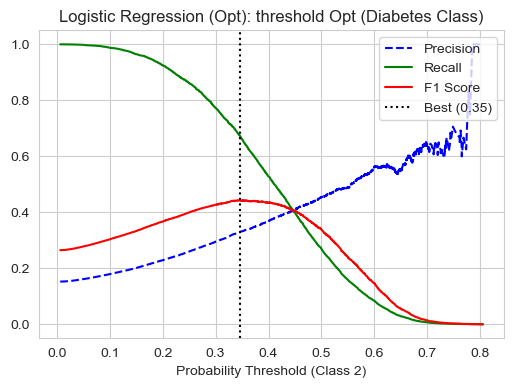

--- Random Forest (Opt) ---
Best Threshold for Class 2: 0.3168
Max F1 for Class 2: 0.3791


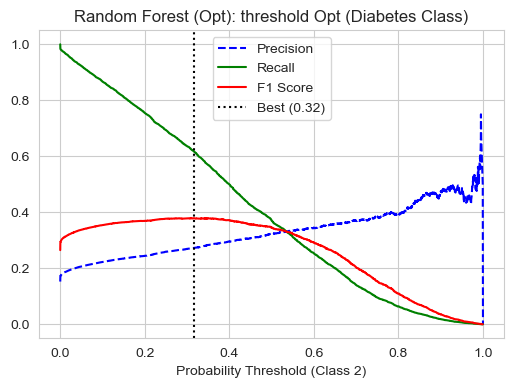

--- XGBoost (Opt) ---
Best Threshold for Class 2: 0.3490
Max F1 for Class 2: 0.3880


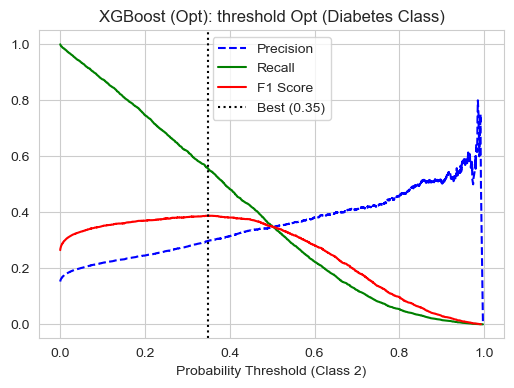

In [6]:
from sklearn.metrics import precision_recall_curve

def optimize_threshold_class2(model, X_val, y_val, name):
    # Get Probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)
    else:
        return
        
    # Focus on Class 2 (Diabetes)
    # y_val is 0,1,2. We want 2 vs Rest.
    y_binary = (y_val == 2).astype(int)
    y_prob_2 = y_proba[:, 2]
    
    precisions, recalls, thresholds = precision_recall_curve(y_binary, y_prob_2)
    
    # Calculate F1 for each threshold
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    
    # Best Threshold for F1
    best_idx = np.nanargmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"--- {name} ---")
    print(f"Best Threshold for Class 2: {best_thresh:.4f}")
    print(f"Max F1 for Class 2: {best_f1:.4f}")
    
    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 Score")
    plt.axvline(best_thresh, color='k', linestyle=':', label=f'Best ({best_thresh:.2f})')
    plt.xlabel("Probability Threshold (Class 2)")
    plt.title(f"{name}: threshold Opt (Diabetes Class)")
    plt.legend()
    plt.show()

# Run for all optimized models
for name, model in models.items():
    optimize_threshold_class2(model, X_test_scaled, y_test, name)

## 4. Final Model Evaluation

Comprehensive evaluation of optimized models is conducted on the held-out test set. Performance metrics include:
*   **Per-Class Precision:** Proportion of predicted instances correctly classified for each health state (Healthy, Prediabetes, Diabetes).
*   **Per-Class Recall:** Proportion of actual instances correctly identified for each class (sensitivity).

*   **Per-Class F1-Score:** Harmonic mean of precision and recall, providing balanced performance measure.This multi-metric evaluation enables assessment of model performance across the full disease spectrum, identifying specific weaknesses in distinguishing between overlapping categories (e.g., Healthy vs. Prediabetes).

*   **Confusion Matrix:** Visualization of classification patterns, revealing misclassification tendencies between adjacent health states.


==================== Logistic Regression (Opt) ====================
              precision    recall  f1-score   support

     Healthy       0.93      0.64      0.76     38012
 Prediabetes       0.03      0.23      0.05       926
    Diabetes       0.35      0.59      0.44      7019

    accuracy                           0.62     45957
   macro avg       0.44      0.49      0.41     45957
weighted avg       0.83      0.62      0.70     45957



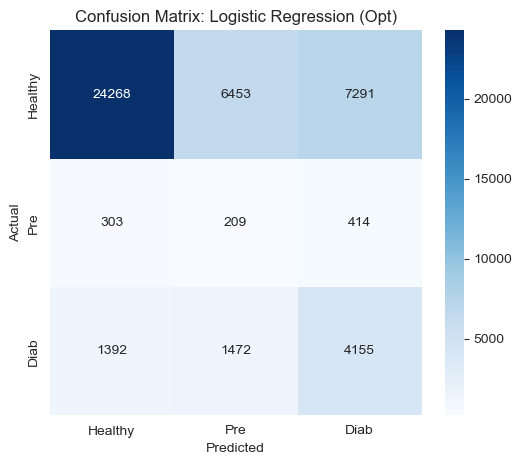


==================== Random Forest (Opt) ====================
              precision    recall  f1-score   support

     Healthy       0.88      0.80      0.84     38012
 Prediabetes       0.03      0.05      0.04       926
    Diabetes       0.31      0.43      0.36      7019

    accuracy                           0.73     45957
   macro avg       0.41      0.43      0.41     45957
weighted avg       0.77      0.73      0.75     45957

              precision    recall  f1-score   support

     Healthy       0.88      0.80      0.84     38012
 Prediabetes       0.03      0.05      0.04       926
    Diabetes       0.31      0.43      0.36      7019

    accuracy                           0.73     45957
   macro avg       0.41      0.43      0.41     45957
weighted avg       0.77      0.73      0.75     45957



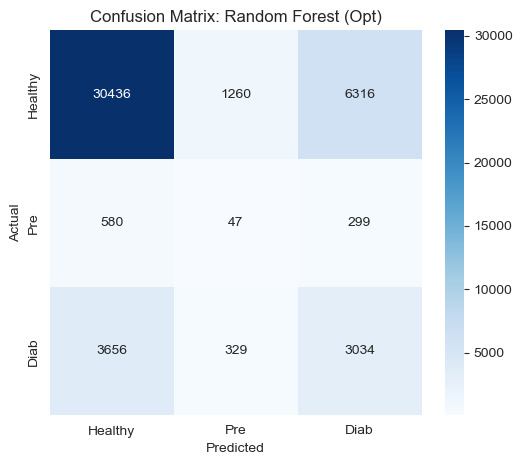


==================== XGBoost (Opt) ====================
              precision    recall  f1-score   support

     Healthy       0.87      0.82      0.85     38012
 Prediabetes       0.02      0.04      0.03       926
    Diabetes       0.33      0.41      0.36      7019

    accuracy                           0.74     45957
   macro avg       0.41      0.42      0.41     45957
weighted avg       0.77      0.74      0.76     45957

              precision    recall  f1-score   support

     Healthy       0.87      0.82      0.85     38012
 Prediabetes       0.02      0.04      0.03       926
    Diabetes       0.33      0.41      0.36      7019

    accuracy                           0.74     45957
   macro avg       0.41      0.42      0.41     45957
weighted avg       0.77      0.74      0.76     45957



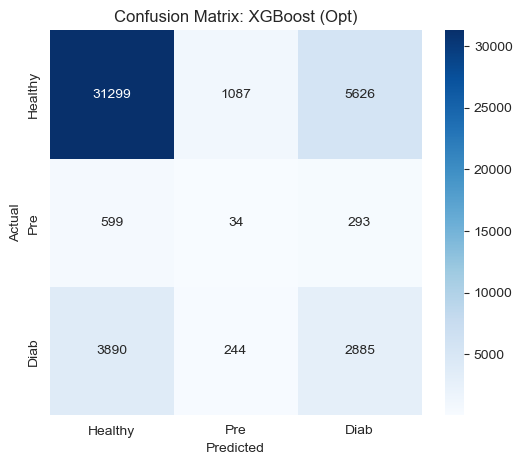

In [7]:
# 7. Evaluate
for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Classification Report
    # Note: Labels 0=Healthy, 1=Prediabetes, 2=Diabetes
    print(classification_report(y_test, y_pred, target_names=['Healthy', 'Prediabetes', 'Diabetes']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Healthy', 'Pre', 'Diab'],
                yticklabels=['Healthy', 'Pre', 'Diab'])
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## 5. Aggregated Weighting Strategy for Prediabetes Detection

Initial model evaluation reveals systematic underperformance on Class 1 (Prediabetes), likely attributable to its intermediate position between Healthy and Diabetes states. To address this challenge, an **aggressive class weighting strategy** is implemented.

### Methodology

**Custom Weight Configuration:** `{0: 1, 1: 50, 2: 5}`
*   **Healthy (Class 0):** Weight = 1 (baseline reference)
*   **Prediabetes (Class 1):** Weight = 50 (maximum priority)
*   **Diabetes (Class 2):** Weight = 5 (elevated priority)

**Implementation Approach:**
*   **Logistic Regression:** Direct application via `class_weight` parameter (scaled data).
*   **Random Forest:** Direct application via `class_weight` parameter (raw data).
*   **XGBoost:** Manual sample weight mapping (as native multi-class `class_weight` parameter is unavailable).

**Rationale:** The extreme weighting (50:1 for Prediabetes) forces the loss function to heavily penalize misclassification of this minority class, potentially improving recall at the expense of overall accuracy or precision. This tradeoff is acceptable in early intervention contexts where identifying at-risk individuals (Prediabetes) is clinically prioritized.

Applying Custom Weights: {0: 1, 1: 50, 2: 5}

Training Weighted Logistic Regression...
Training Weighted Random Forest...
Training Weighted Random Forest...
Training Weighted XGBoost...
Training Weighted XGBoost...

==================== Weighted LogReg ====================
              precision    recall  f1-score   support

     Healthy       0.95      0.55      0.70     38012
 Prediabetes       0.03      0.59      0.05       926
    Diabetes       0.43      0.30      0.35      7019

    accuracy                           0.51     45957
   macro avg       0.47      0.48      0.37     45957
weighted avg       0.85      0.51      0.63     45957


==================== Weighted LogReg ====================
              precision    recall  f1-score   support

     Healthy       0.95      0.55      0.70     38012
 Prediabetes       0.03      0.59      0.05       926
    Diabetes       0.43      0.30      0.35      7019

    accuracy                           0.51     45957
   macro avg  

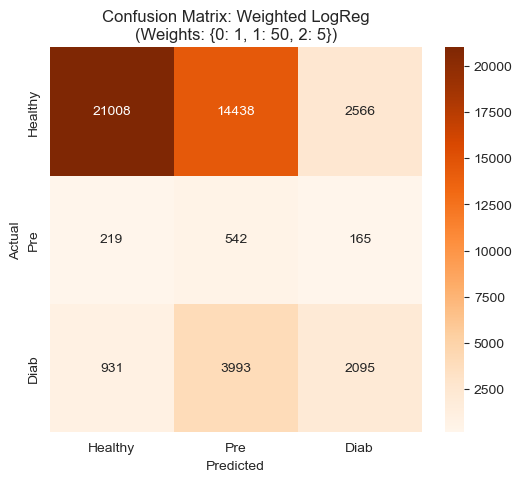


==================== Weighted RF ====================
              precision    recall  f1-score   support

     Healthy       0.87      0.73      0.80     38012
 Prediabetes       0.03      0.17      0.05       926
    Diabetes       0.29      0.34      0.31      7019

    accuracy                           0.66     45957
   macro avg       0.40      0.41      0.39     45957
weighted avg       0.77      0.66      0.71     45957



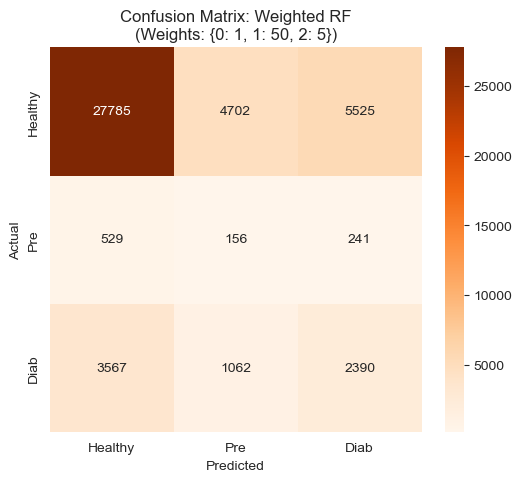


==================== Weighted XGBoost ====================
              precision    recall  f1-score   support

     Healthy       0.94      0.55      0.69     38012
 Prediabetes       0.03      0.46      0.05       926
    Diabetes       0.36      0.42      0.39      7019

    accuracy                           0.53     45957
   macro avg       0.44      0.48      0.38     45957
weighted avg       0.84      0.53      0.63     45957



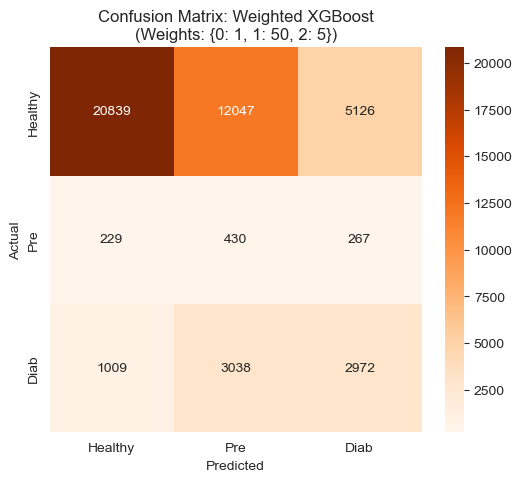

In [8]:
# --- Aggregated Weighting Strategy ---

# 1. Define Aggressive Weights
custom_weights = {0: 1, 1: 50, 2: 5}
print(f"Applying Custom Weights: {custom_weights}")

# 2. Train Weighted Models

# A. Logistic Regression (Weighted)
print("\nTraining Weighted Logistic Regression...")
# Note: multi_class='multinomial' is implicit with solver='lbfgs' in newer sklearn
lr_weighted = LogisticRegression(
    class_weight=custom_weights,
    solver='lbfgs',
    max_iter=2000,
    random_state=42
)
# Fit on Scaled Training Data
lr_weighted.fit(X_train_scaled, y_train) 

# B. Random Forest (Weighted)
print("Training Weighted Random Forest...")
rf_weighted = RandomForestClassifier(
    n_estimators=100,
    class_weight=custom_weights,
    random_state=42,
    n_jobs=-1
)
# Fit on Raw Training Data (RF handles unscaled fine)
rf_weighted.fit(X_train, y_train)

# C. XGBoost (Weighted)
print("Training Weighted XGBoost...")
# XGBoost doesn't support class_weight directly for multi-class. We map weights to samples.
sample_weights = y_train.map(custom_weights)

xgb_weighted = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=100,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)
xgb_weighted.fit(X_train, y_train, sample_weight=sample_weights)

# 3. Evaluation Dictionary
weighted_models = {
    "Weighted LogReg": (lr_weighted, X_test_scaled),
    "Weighted RF": (rf_weighted, X_test),
    "Weighted XGBoost": (xgb_weighted, X_test)
}

# 4. Evaluate & Plot
for name, (model, X_eval) in weighted_models.items():
    print(f"\n{'='*20} {name} {'='*20}")
    
    # Predict
    y_pred = model.predict(X_eval)
    
    # Classification Report
    print(classification_report(y_test, y_pred, target_names=['Healthy', 'Prediabetes', 'Diabetes']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=['Healthy', 'Pre', 'Diab'],
                yticklabels=['Healthy', 'Pre', 'Diab'])
    plt.title(f'Confusion Matrix: {name}\n(Weights: {custom_weights})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## 6. Ensemble Approach (Balanced Random Forest)

To further address class imbalance challenges, the **Balanced Random Forest Classifier** from `imblearn.ensemble` is deployed. This specialized ensemble method incorporates automatic balancing mechanisms:

**Architecture:**
*   **Bootstrap Sampling:** Each tree in the forest is trained on a balanced bootstrap sample, achieved through internal downsampling of the majority class.

*   **Sampling Strategy:** `'all'` configuration ensures all classes are balanced within each tree's training data.**Training Configuration:** The model is fitted directly on the original stratified train-test split (without external SMOTE), as the algorithm handles balancing internally. This approach aims to capture Class 1 (Prediabetes) patterns more effectively than standard Random Forest through its inherent minority class emphasis.

*   **Advantage:** Unlike SMOTE which creates synthetic samples globally, Balanced Random Forest applies balancing locally within each tree, potentially reducing overfitting to synthetic patterns.

Multi-Class Ensemble (Balanced Random Forest):

Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.71     38012
           1       0.03      0.26      0.05       926
           2       0.30      0.57      0.40      7019

    accuracy                           0.57     45957
   macro avg       0.42      0.47      0.39     45957
weighted avg       0.82      0.57      0.65     45957


Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.71     38012
           1       0.03      0.26      0.05       926
           2       0.30      0.57      0.40      7019

    accuracy                           0.57     45957
   macro avg       0.42      0.47      0.39     45957
weighted avg       0.82      0.57      0.65     45957



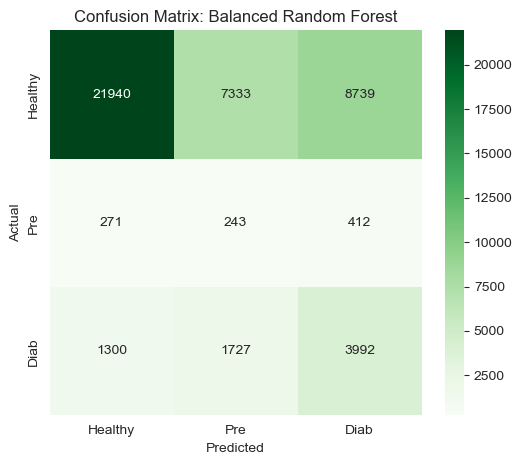

In [9]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

print("Multi-Class Ensemble (Balanced Random Forest):")

# Initialize brf_model
brf_model = BalancedRandomForestClassifier(
    n_estimators=100, 
    sampling_strategy='all', 
    random_state=42,
    n_jobs=-1
)

# Fit directly on the Standard/Stratified Split training data (not the SMOTE data)
# Using X_train and y_train (raw/scaled split, before external resampling)
brf_model.fit(X_train, y_train)

# Predict and print the Classification Report
y_pred_brf = brf_model.predict(X_test)

print("\nBalanced Random Forest Classification Report:")
print(classification_report(y_test, y_pred_brf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_brf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Healthy', 'Pre', 'Diab'],
            yticklabels=['Healthy', 'Pre', 'Diab'])
plt.title('Confusion Matrix: Balanced Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 7. Balanced Random Forest Optimization

Hyperparameter optimization is conducted for the Balanced Random Forest using Optuna with a critical metric modification:

**Optimization Metric:** `f1_macro` (Macro-averaged F1 Score)


**Rationale for Metric Selection:**The optimization process comprises 20 trials with 3-fold stratified cross-validation, explicitly prioritizing minority class performance through the macro-averaging approach.

*   **F1-weighted Limitation:** Weights F1 scores by class support, resulting in bias toward the majority class (Healthy). High weighted F1 can be achieved while ignoring minority classes.

*   **F1-macro Advantage:** Calculates unweighted mean of per-class F1 scores, treating Healthy, Prediabetes, and Diabetes equally. This forces the optimizer to improve performance on difficult minority classes rather than optimizing only majority class predictions.*   Maximum features for splits ('sqrt', 'log2')

*   Minimum samples per split/leaf (2-10, 1-10)

**Hyperparameters Tuned:***   Maximum tree depth (5-30)
*   Number of estimators (100-500)

[I 2026-02-07 10:54:37,073] A new study created in memory with name: no-name-886b707c-72c8-4c5f-8a09-237b2d74f5d9


Optimizing Balanced Random Forest (Metric: F1 Macro)...


Best trial: 0. Best value: 0.398549:   5%|▌         | 1/20 [00:11<03:33, 11.26s/it]

[I 2026-02-07 10:54:48,329] Trial 0 finished with value: 0.39854929939758416 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.39854929939758416.


Best trial: 1. Best value: 0.399521:  10%|█         | 2/20 [00:17<02:25,  8.09s/it]

[I 2026-02-07 10:54:54,206] Trial 1 finished with value: 0.3995211785030773 and parameters: {'n_estimators': 123, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 0.3995211785030773.


Best trial: 2. Best value: 0.400983:  15%|█▌        | 3/20 [00:35<03:38, 12.86s/it]

[I 2026-02-07 10:55:12,750] Trial 2 finished with value: 0.40098273897964026 and parameters: {'n_estimators': 433, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  20%|██        | 4/20 [00:47<03:21, 12.57s/it]

[I 2026-02-07 10:55:24,858] Trial 3 finished with value: 0.40000874840676676 and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  25%|██▌       | 5/20 [01:00<03:07, 12.47s/it]

[I 2026-02-07 10:55:37,167] Trial 4 finished with value: 0.3987604034136472 and parameters: {'n_estimators': 282, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  30%|███       | 6/20 [01:14<03:03, 13.14s/it]

[I 2026-02-07 10:55:51,592] Trial 5 finished with value: 0.4009099696224792 and parameters: {'n_estimators': 343, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  35%|███▌      | 7/20 [01:24<02:36, 12.00s/it]

[I 2026-02-07 10:56:01,259] Trial 6 finished with value: 0.3998189081976247 and parameters: {'n_estimators': 222, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  40%|████      | 8/20 [01:29<01:57,  9.77s/it]

[I 2026-02-07 10:56:06,252] Trial 7 finished with value: 0.3983737646323345 and parameters: {'n_estimators': 113, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  45%|████▌     | 9/20 [01:42<01:59, 10.86s/it]

[I 2026-02-07 10:56:19,490] Trial 8 finished with value: 0.40058067587463064 and parameters: {'n_estimators': 319, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  50%|█████     | 10/20 [01:57<02:01, 12.19s/it]

[I 2026-02-07 10:56:34,669] Trial 9 finished with value: 0.39225445035292744 and parameters: {'n_estimators': 339, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  55%|█████▌    | 11/20 [02:19<02:17, 15.27s/it]

[I 2026-02-07 10:56:56,939] Trial 10 finished with value: 0.3935581885070089 and parameters: {'n_estimators': 492, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 2. Best value: 0.400983:  60%|██████    | 12/20 [02:38<02:09, 16.22s/it]

[I 2026-02-07 10:57:15,331] Trial 11 finished with value: 0.4008740385456966 and parameters: {'n_estimators': 430, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.40098273897964026.


Best trial: 12. Best value: 0.401026:  65%|██████▌   | 13/20 [02:54<01:53, 16.19s/it]

[I 2026-02-07 10:57:31,436] Trial 12 finished with value: 0.4010262274000757 and parameters: {'n_estimators': 388, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.4010262274000757.


Best trial: 13. Best value: 0.401058:  70%|███████   | 14/20 [03:11<01:39, 16.58s/it]

[I 2026-02-07 10:57:48,922] Trial 13 finished with value: 0.40105780533983587 and parameters: {'n_estimators': 413, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.40105780533983587.


Best trial: 13. Best value: 0.401058:  75%|███████▌  | 15/20 [03:28<01:23, 16.67s/it]

[I 2026-02-07 10:58:05,787] Trial 14 finished with value: 0.40087249984511203 and parameters: {'n_estimators': 407, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.40105780533983587.


Best trial: 13. Best value: 0.401058:  80%|████████  | 16/20 [03:50<01:12, 18.13s/it]

[I 2026-02-07 10:58:27,332] Trial 15 finished with value: 0.39795564769887437 and parameters: {'n_estimators': 496, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.40105780533983587.


Best trial: 13. Best value: 0.401058:  85%|████████▌ | 17/20 [04:05<00:52, 17.41s/it]

[I 2026-02-07 10:58:43,056] Trial 16 finished with value: 0.4010534218184068 and parameters: {'n_estimators': 381, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.40105780533983587.


Best trial: 13. Best value: 0.401058:  90%|█████████ | 18/20 [04:22<00:34, 17.15s/it]

[I 2026-02-07 10:58:59,598] Trial 17 finished with value: 0.39799879358923107 and parameters: {'n_estimators': 374, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.40105780533983587.


Best trial: 13. Best value: 0.401058:  95%|█████████▌| 19/20 [04:43<00:18, 18.18s/it]

[I 2026-02-07 10:59:20,192] Trial 18 finished with value: 0.3986595266257497 and parameters: {'n_estimators': 446, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.40105780533983587.


Best trial: 13. Best value: 0.401058: 100%|██████████| 20/20 [04:52<00:00, 14.60s/it]



[I 2026-02-07 10:59:29,126] Trial 19 finished with value: 0.4005763398534316 and parameters: {'n_estimators': 205, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.40105780533983587.

Best Params: {'n_estimators': 413, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Best F1 Macro: 0.4011

==================== Final Balanced Random Forest (Optimized) ====================
              precision    recall  f1-score   support

     Healthy       0.94      0.60      0.73     38012
 Prediabetes       0.03      0.22      0.05       926
    Diabetes       0.32      0.65      0.43      7019

    accuracy                           0.60     45957
   macro avg       0.43      0.49      0.40     45957
weighted avg       0.83      0.60      0.67     45957

              precision    recall  f1-score   support

     Healthy       0.94      0.60      0.73     38012
 Prediabetes       0.03     

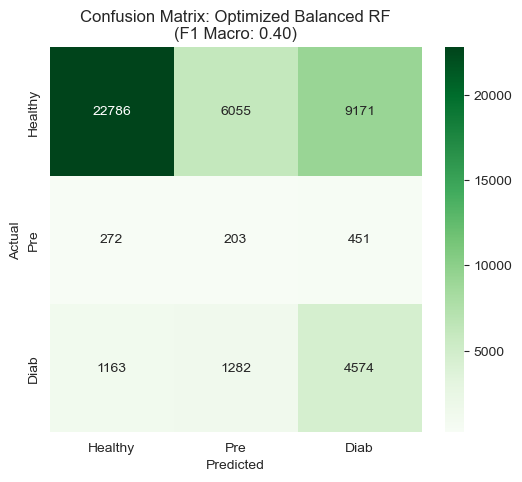

In [10]:
# --- Hyperparameter Optimization for Balanced Random Forest ---

def objective_brf(trial):
    # Hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    # Model
    # sampling_strategy='all' ensures all classes are balanced in each boostrap sample
    model = BalancedRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        sampling_strategy='all', 
        random_state=42,
        n_jobs=-1
    )
    
    # Cross Validation
    # Use StratifiedKFold on the RAW training data (model handles balancing internally)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # optimize for 'f1_macro' to explicitly value the minority classes equally
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro')
    
    return scores.mean()

print("Optimizing Balanced Random Forest (Metric: F1 Macro)...")
study_brf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_brf.optimize(objective_brf, n_trials=20, show_progress_bar=True)

print(f"\nBest Params: {study_brf.best_params}")
print(f"Best F1 Macro: {study_brf.best_value:.4f}")


# --- Final Evaluation of Optimized Model ---
print("\n" + "="*20 + " Final Balanced Random Forest (Optimized) " + "="*20)

best_brf = BalancedRandomForestClassifier(
    **study_brf.best_params,
    sampling_strategy='all',
    random_state=42,
    n_jobs=-1
)

best_brf.fit(X_train, y_train)
y_pred_best_brf = best_brf.predict(X_test)

print(classification_report(y_test, y_pred_best_brf, target_names=['Healthy', 'Prediabetes', 'Diabetes']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_brf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Healthy', 'Pre', 'Diab'],
            yticklabels=['Healthy', 'Pre', 'Diab'])
plt.title(f'Confusion Matrix: Optimized Balanced RF\n(F1 Macro: {study_brf.best_value:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 8. Threshold Optimization for Balanced Random Forest

Further refinement of the Balanced Random Forest involves probability threshold optimization specifically for **Class 2 (Diabetes)** detection.

**Methodology:**

*   **Binary Reformulation:** The multi-class probabilities are analyzed through a binary lens (Diabetes vs. Non-Diabetes) for Class 2.This strategy increases model sensitivity to the most severe health state, potentially improving early detection of diabetes cases that might otherwise be misclassified due to overlapping probability distributions with Prediabetes.

*   **Precision-Recall Analysis:** A comprehensive precision-recall curve is constructed across probability thresholds to identify the optimal decision boundary.

*   **F1 Maximization:** The threshold maximizing F1-score for Class 2 is selected, balancing precision (minimizing false alarms) and recall (maximizing case detection).*   **Selective Override:** Predictions are modified such that any instance with Class 2 probability exceeding the optimized threshold is classified as Diabetes, regardless of argmax outcome.

Optimal Threshold for Class 2 (Diabetes): 0.3896 (Max F1: 0.4461)


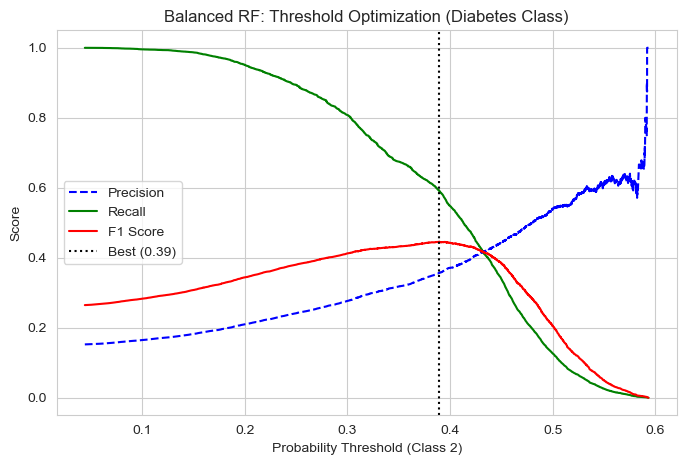


==================== Balanced RF (Class 2 Threshold Opt) ====================
              precision    recall  f1-score   support

     Healthy       0.94      0.60      0.73     38012
 Prediabetes       0.03      0.21      0.05       926
    Diabetes       0.32      0.66      0.43      7019

    accuracy                           0.60     45957
   macro avg       0.43      0.49      0.40     45957
weighted avg       0.83      0.60      0.67     45957



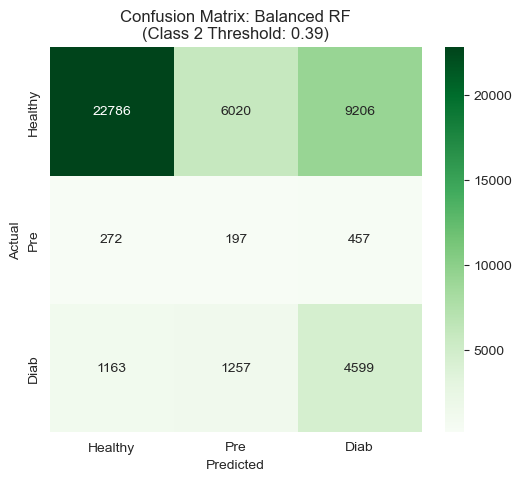

In [11]:
from sklearn.metrics import precision_recall_curve

# 1. Visualize Threshold Optimization (using previously defined function if available, or simpler inline logic)
# (Assuming optimize_threshold_class2 was defined in earlier cells. If not, we re-implement logic to be safe)

# Get probabilities
y_proba_brf = best_brf.predict_proba(X_test)
y_test_binary_2 = (y_test == 2).astype(int)

# Precision-Recall Curve for Class 2
precisions, recalls, thresholds = precision_recall_curve(y_test_binary_2, y_proba_brf[:, 2])

# F1 Scores
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find Best Threshold
best_idx = np.nanargmax(f1_scores)
best_thresh_2 = thresholds[best_idx]
best_f1_2 = f1_scores[best_idx]

print(f"Optimal Threshold for Class 2 (Diabetes): {best_thresh_2:.4f} (Max F1: {best_f1_2:.4f})")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 Score")
plt.axvline(best_thresh_2, color='k', linestyle=':', label=f'Best ({best_thresh_2:.2f})')
plt.xlabel("Probability Threshold (Class 2)")
plt.ylabel("Score")
plt.title("Balanced RF: Threshold Optimization (Diabetes Class)")
plt.legend()
plt.show()

# 2. Apply Optimized Threshold
# default prediction
y_pred_opt_brf = best_brf.predict(X_test)

# Overwrite with Class 2 if prob >= best_threshold
# This increases sensitivity for Diabetes
# Note: This strategy prioritizes Class 2 over Class 1/0
y_pred_opt_brf[y_proba_brf[:, 2] >= best_thresh_2] = 2

print("\n" + "="*20 + " Balanced RF (Class 2 Threshold Opt) " + "="*20)
print(classification_report(y_test, y_pred_opt_brf, target_names=['Healthy', 'Prediabetes', 'Diabetes']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_opt_brf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Healthy', 'Pre', 'Diab'],
            yticklabels=['Healthy', 'Pre', 'Diab'])
plt.title(f'Confusion Matrix: Balanced RF\n(Class 2 Threshold: {best_thresh_2:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 9. SHAP Analysis (Model Interpretation)

Model interpretability is established through SHAP (SHapley Additive exPlanations) analysis, providing rigorous feature attribution for predictions.

**Analysis Configuration:**
*   **Target Model:** Optimized XGBoost classifier (selected for superior performance and efficient SHAP computation).

*   **Focus:** Feature contributions to **Class 2 (Diabetes)** predictions.This analysis reveals which clinical and lifestyle factors drive the model's diabetes risk assessments, enabling validation against medical domain knowledge and identification of potential algorithmic biases.

*   **Sample Size:** 2,000 randomly selected test instances (for computational efficiency).

    *   Color: Feature value (red = high, blue = low)

**Visualization:**    *   Y-axis: Feature ranking by importance

*   **Beeswarm Plot:** Global interpretation summarizing feature impact across the test set. Each point represents a single prediction, with:    *   X-axis: SHAP value (positive = increases Diabetes risk, negative = decreases risk)

Subsampling 2000 data points for SHAP analysis...
Initializing SHAP TreeExplainer...
Multi-class Output (3D Array). Selecting Class 2 (Diabetes).

SHAP Summary Plot: Global Drivers of Diabetes Prediction
Multi-class Output (3D Array). Selecting Class 2 (Diabetes).

SHAP Summary Plot: Global Drivers of Diabetes Prediction


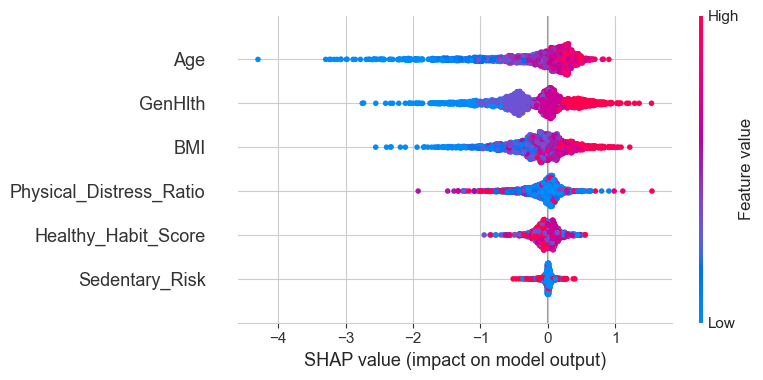

In [12]:
import shap

# Initialize SHAP
shap.initjs()

# 1. Select Model and Data
# We analyze 'best_xgb' (Optimized XGBoost). 
xgb_model = best_xgb

# --- Sampling for Efficiency ---
N_SAMPLES = 2000
print(f"Subsampling {N_SAMPLES} data points for SHAP analysis...")

if len(X_test) > N_SAMPLES:
    # Sample indices
    # Use pandas sampling for the raw dataframe
    X_shap_plot = X_test.sample(n=N_SAMPLES, random_state=42)
    # Get corresponding indices for the scaled array
    sample_indices = X_test.index.get_indexer(X_shap_plot.index)
    X_shap_calc = X_test_scaled[sample_indices]
else:
    X_shap_plot = X_test
    X_shap_calc = X_test_scaled

print("Initializing SHAP TreeExplainer...")
try:
    explainer = shap.TreeExplainer(xgb_model)
    # Calculate SHAP values on the standard input (Scaled)
    shap_values = explainer.shap_values(X_shap_calc)
    
    # 2. Handle Multi-Class Output
    # XGBoost shap_values can be a list [class0, class1, class2] or a 3D array (samples, features, classes)
    if isinstance(shap_values, list):
        print("Multi-class Output (List). Selecting Class 2 (Diabetes).")
        sv_diabetes = shap_values[2] # Class 2
    elif len(shap_values.shape) == 3:
        print("Multi-class Output (3D Array). Selecting Class 2 (Diabetes).")
        sv_diabetes = shap_values[:, :, 2] # Class 2
    else:
        print("Binary Output. Using default SHAP values.")
        sv_diabetes = shap_values

    # 3. Summary Plot (Beeswarm)
    # We use X_shap_plot (Raw DF sample) for the 'features' argument so the plot shows:
    # - Correct feature names (from DF columns)
    # - Interpretable raw feature values (e.g., Age=60) on the color bar
    print("\nSHAP Summary Plot: Global Drivers of Diabetes Prediction")
    plt.figure()
    shap.summary_plot(sv_diabetes, X_shap_plot, plot_type="dot")

except Exception as e:
    print(f"Error during SHAP analysis: {e}")
    print("Ensure 'shap' is installed (pip install shap).")

## 10. Final Model Comparison Leaderboard

The following table summarizes the performance of all models evaluated in this notebook, ranked by their ability to detect the minority class (Prediabetes) and overall balanced performance (F1 Macro).

In [13]:
# --- Final Model Comparison Leaderboard ---
from sklearn.metrics import recall_score, f1_score, accuracy_score

# 1. Gather all models into a single dictionary
all_models_eval = {}

# Add Standard Models (from Section 2/4)
for name, model in models.items():
    all_models_eval[name] = (model, X_test_scaled)

# Add Weighted Models (from Section 5)
# Note: weighted_models store tuple (model, correct_X)
for name, (model, X_eval) in weighted_models.items():
    all_models_eval[name] = (model, X_eval)

# Add Balanced RF (Manual from Section 6)
all_models_eval["Balanced RF (Default)"] = (brf_model, X_test) # Uses Raw X_test

# Add Optimized Balanced RF (Section 7)
all_models_eval["Balanced RF (Opt)"] = (best_brf, X_test)

# 2. Calculate Metrics
results_list = []

for name, (model, X_eval) in all_models_eval.items():
    y_p = model.predict(X_eval)
    
    # Calculate Per-Class Recall manually to ensure we catch 0/1/2 correctly
    # average=None returns array: [recall_0, recall_1, recall_2]
    recalls = recall_score(y_test, y_p, average=None)
    
    # Overall Metrics
    acc = accuracy_score(y_test, y_p)
    f1_macro = f1_score(y_test, y_p, average='macro')
    
    results_list.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Macro': f1_macro,
        'Recall (Healthy)': recalls[0],
        'Recall (Prediabetes)': recalls[1], # Critical Metric
        'Recall (Diabetes)': recalls[2]     # Critical Metric
    })

# 3. Create DataFrame
leaderboard = pd.DataFrame(results_list)
leaderboard.set_index('Model', inplace=True)

# 4. Display sorted by specific goals
print("\n--- Leaderboard: Ranked by Prediabetes Detection (Recall Class 1) ---")
display(leaderboard.sort_values(by='Recall (Prediabetes)', ascending=False).style.background_gradient(cmap='Greens'))

print("\n--- Leaderboard: Ranked by F1 Macro (Balanced Performance) ---")
display(leaderboard.sort_values(by='F1 Macro', ascending=False).style.background_gradient(cmap='Greens'))


--- Leaderboard: Ranked by Prediabetes Detection (Recall Class 1) ---


,Accuracy,F1 Macro,Recall (Healthy),Recall (Prediabetes),Recall (Diabetes)
Model,,,,,
Weighted LogReg,0.514503,0.368833,0.552668,0.585313,0.298476
Weighted XGBoost,0.527471,0.377429,0.548222,0.464363,0.423422
Balanced RF (Default),0.569554,0.385578,0.577186,0.262419,0.568742
Logistic Regression (Opt),0.623017,0.414993,0.638430,0.225702,0.591965
Balanced RF (Opt),0.599756,0.403814,0.599442,0.219222,0.651660
Weighted RF,0.659987,0.385213,0.730953,0.168467,0.340504
Random Forest (Opt),0.729312,0.412743,0.800695,0.050756,0.432255
XGBoost (Opt),0.744566,0.414184,0.823398,0.036717,0.411027



--- Leaderboard: Ranked by F1 Macro (Balanced Performance) ---


,Accuracy,F1 Macro,Recall (Healthy),Recall (Prediabetes),Recall (Diabetes)
Model,,,,,
Logistic Regression (Opt),0.623017,0.414993,0.638430,0.225702,0.591965
XGBoost (Opt),0.744566,0.414184,0.823398,0.036717,0.411027
Random Forest (Opt),0.729312,0.412743,0.800695,0.050756,0.432255
Balanced RF (Opt),0.599756,0.403814,0.599442,0.219222,0.651660
Balanced RF (Default),0.569554,0.385578,0.577186,0.262419,0.568742
Weighted RF,0.659987,0.385213,0.730953,0.168467,0.340504
Weighted XGBoost,0.527471,0.377429,0.548222,0.464363,0.423422
Weighted LogReg,0.514503,0.368833,0.552668,0.585313,0.298476


In [ ]:
## 11. Automated Model Selection

Based on comprehensive evaluation criteria (balanced recall across all classes, high F1 Macro score, and overall accuracy), the following automated recommendation identifies the champion model for deployment in multi-class diabetes risk prediction.


 AUTOMATED MODEL SELECTION
 Criteria: Good F1, High Accuracy, Decent Recall (>30%) for ALL classes

 CHAMPION MODEL: Weighted XGBoost
   Reason: Meets strict balance criteria (>30% recall all classes) + Highest F1
----------------------------------------
   Accuracy:         52.75%
   F1 Macro:         37.74%
   Min Recall:       42.34% (The bottleneck)
----------------------------------------
   Recall (Healthy): 54.82%
   Recall (Pre):     46.44%
   Recall (Diab):    42.34%


In [ ]:
# --- Automated Recommendation: Best Overall Model ---

print("\n" + "="*60)
print(" AUTOMATED MODEL SELECTION")
print(" Criteria: Good F1, High Accuracy, Decent Recall (>30%) for ALL classes")
print("="*60)

# 1. Define "Decent Recall"
# We check the minimum recall across all 3 classes for each model
leaderboard['Min Recall'] = leaderboard[['Recall (Healthy)', 'Recall (Prediabetes)', 'Recall (Diabetes)']].min(axis=1)

# 2. Filter Models
# Threshold: At least 30% recall for the hardest class (usually Prediabetes). 
# If 30% is too strict for your data, code falls back to 10% or just Max F1.
candidates_strict = leaderboard[leaderboard['Min Recall'] >= 0.3]
candidates_loose  = leaderboard[leaderboard['Min Recall'] >= 0.1]

target_model = ""
reason = ""

if not candidates_strict.empty:
    # Case A: We have robust models. Pick the one with highest F1 Macro.
    target_model = candidates_strict['F1 Macro'].idxmax()
    reason = "Meets strict balance criteria (>30% recall all classes) + Highest F1"
elif not candidates_loose.empty:
    # Case B: Hard to find balanced models. Pick best of the "okay" ones.
    target_model = candidates_loose['F1 Macro'].idxmax()
    reason = "Meets loose balance criteria (>10% recall all classes) + Highest F1"
else:
    # Case C: All models fail minority class. Just pick best F1.
    target_model = leaderboard['F1 Macro'].idxmax()
    reason = "No balanced models found. Fallback to highest F1 Macro."

# 3. Display Result
best_row = leaderboard.loc[target_model]

print(f"\n🏆 CHAMPION MODEL: {target_model}")
print(f"   Reason: {reason}")
print("-" * 40)
print(f"   Accuracy:         {best_row['Accuracy']:.2%}")
print(f"   F1 Macro:         {best_row['F1 Macro']:.2%}")
print(f"   Min Recall:       {best_row['Min Recall']:.2%} (The bottleneck)")
print("-" * 40)
print(f"   Recall (Healthy): {best_row['Recall (Healthy)']:.2%}")
print(f"   Recall (Pre):     {best_row['Recall (Prediabetes)']:.2%}")
print(f"   Recall (Diab):    {best_row['Recall (Diabetes)']:.2%}")